# Rede Neural Recorrente simples para classificar dígitos MNIST

Este experimento ilustra o uso de uma rede neural recorrente na tarefa de classificação
de dígitos manuscritos do dataset MNIST.

A imagem é estruturada em 28 sequências de 28 pixels cada. Cada elemento da sequência é
formado por uma linha da imagem. Cada linha da imagem contém 28 atributos (pixels).

<img src='../figures/RNN_MNIST.png', width= 700></img>

**Obs:** Este experimento foi inspirado no artigo:
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf

A principal modificação é a formatação da imagem em 28 sequências de 28 pixels.

## Importação

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from   torch.autograd import Variable

import torchvision

import lib.pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Leitura do dataset

In [29]:
dataset_dir = '/data/datasets/MNIST/'

datax_train, datay_train = torch.load(dataset_dir + 'processed/training.pt')
datax_test,  datay_test  = torch.load(dataset_dir + 'processed/test.pt')

datax_train = datax_train.float() / 255.
datax_test  = datax_test.float() / 255.

## Pouquíssimas amostras - depurando apenas

In [30]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500
else:
    n_samples_train = datax_train.size(0)
    n_samples_test  = datax_test.size(0)
    
x_train = datax_train[:n_samples_train]
y_train = datay_train[:n_samples_train]
x_test  = datax_test[:n_samples_test]
y_test  = datay_test[:n_samples_test]

In [14]:
x_train.shape

torch.Size([60000, 28, 28])

## SimpleRNN com 100 neurônios

In [15]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,x = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    

model_rnn = Model_RNN(100)
if use_gpu:
    model_rnn = model_rnn.cuda()
model_rnn

Model_RNN (
  (rnn): RNN(28, 100, batch_first=True, dropout=0.05)
  (out): Linear (100 -> 10)
)

## Predict com uma amostra

In [16]:
xin = x_train[0:1]
xin = torch.zeros((1,28,28))
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_rnn(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([1, 28, 28])
Variable containing:
 0.0773
-0.0741
-0.0478
-0.0038
 0.1620
-0.0026
-0.0380
 0.0150
 0.0045
 0.0537
[torch.cuda.FloatTensor of size 10 (GPU 0)]



## Criando o treinador

In [17]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_t', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model_rnn,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.Adam(model_rnn.parameters(),lr=1e-3),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [18]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)

Start training for 20 epochs
  1:   4.6s   T: 0.68101 0.76970   V: 0.33845 0.89930 best
  2:   4.5s   T: 0.31000 0.90733   V: 0.24840 0.92170 best
  3:   4.5s   T: 0.24744 0.92668   V: 0.19533 0.94080 best
  4:   4.4s   T: 0.20373 0.94132   V: 0.18599 0.94630 best
  5:   4.5s   T: 0.17559 0.94932   V: 0.15068 0.95570 best
  6:   4.5s   T: 0.15685 0.95507   V: 0.17643 0.94680 
  7:   4.5s   T: 0.14610 0.95780   V: 0.13883 0.96290 best
  8:   4.5s   T: 0.13069 0.96288   V: 0.13359 0.96060 best
  9:   4.5s   T: 0.12087 0.96555   V: 0.10576 0.97000 best
 10:   4.5s   T: 0.11473 0.96787   V: 0.13184 0.96780 
 11:   4.5s   T: 0.11229 0.96770   V: 0.11563 0.96910 
 12:   4.5s   T: 0.10652 0.97020   V: 0.09957 0.97050 best
 13:   4.5s   T: 0.10054 0.97173   V: 0.12366 0.96420 
 14:   4.5s   T: 0.10091 0.97173   V: 0.09998 0.97270 
 15:   4.5s   T: 0.09645 0.97247   V: 0.09089 0.97350 best
 16:   4.5s   T: 0.09180 0.97487   V: 0.10990 0.96740 
 17:   4.4s   T: 0.09229 0.97423   V: 0.08893 0.975

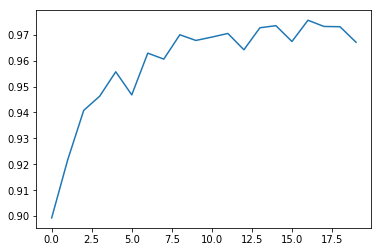

In [19]:
plt.plot(trainer.metrics['valid']['acc'])

## Usando LSTM

In [20]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
model_lstm = Model_LSTM(100)
if use_gpu:
    model_lstm = model_lstm.cuda()

### Predict com uma amostra

In [21]:
xin = x_train[0:1]
xin = torch.zeros((1,28,28))
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_lstm(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([1, 28, 28])
Variable containing:
-0.0461
-0.0470
-0.0207
-0.0390
-0.1061
 0.0903
-0.0442
-0.0328
 0.0375
 0.0611
[torch.cuda.FloatTensor of size 10 (GPU 0)]



### Criando o treinador

In [24]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_lstm', reset=True, verbose=1)

trainer_lstm = ptt.DeepNetTrainer(
                model_lstm,
                criterion = nn.CrossEntropyLoss(),
                optimizer = torch.optim.Adam(model_lstm.parameters(),lr=1e-3),
                callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                )

In [25]:
trainer_lstm.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)

Start training for 20 epochs
  1:   6.0s   T: 0.43526 0.86082   V: 0.17086 0.94750 best
  2:   5.6s   T: 0.14115 0.95792   V: 0.11651 0.96370 best
  3:   5.6s   T: 0.09703 0.97047   V: 0.07900 0.97700 best
  4:   5.6s   T: 0.07580 0.97757   V: 0.07050 0.97770 best
  5:   5.6s   T: 0.05955 0.98195   V: 0.06605 0.98100 best
  6:   5.6s   T: 0.05023 0.98470   V: 0.06118 0.98190 best
  7:   5.6s   T: 0.04391 0.98635   V: 0.06083 0.98200 best
  8:   5.6s   T: 0.03895 0.98803   V: 0.05865 0.98430 best
  9:   5.6s   T: 0.03401 0.98940   V: 0.05242 0.98450 best
 10:   5.6s   T: 0.02884 0.99138   V: 0.05575 0.98420 
 11:   5.6s   T: 0.02699 0.99167   V: 0.04844 0.98510 best
 12:   5.6s   T: 0.02496 0.99267   V: 0.04351 0.98670 best
 13:   5.6s   T: 0.02103 0.99362   V: 0.04415 0.98730 
 14:   5.6s   T: 0.02247 0.99262   V: 0.04223 0.98840 best
 15:   5.6s   T: 0.01661 0.99480   V: 0.04322 0.98760 
 16:   5.6s   T: 0.01736 0.99427   V: 0.04557 0.98820 
 17:   5.6s   T: 0.01615 0.99488   V: 0.043

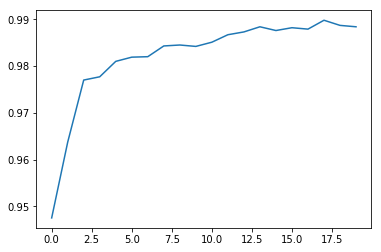

In [26]:
plt.plot(trainer_lstm.metrics['valid']['acc'])

## Comparação RNN x LSTM

    - Acurácia RNN: 97,5%
    - Acurácia LSTM: 98,9%

# Exercícios

In [ ]:
1. 